In [7]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
import hdbscan
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import gc
warnings.filterwarnings("ignore", category=UserWarning)

# Leitura do dataset
df_base = pd.read_csv("df_base.csv")


In [8]:
def cluster_two_steps_with_exog(df, series_cols, exog_cols=None, 
                                geo_alg="hdbscan", time_alg="kmeans",
                                n_geo=4, n_time=4, n_pca_series=3, 
                                random_state=42, max_cluster_size=None):
    df = df.dropna(subset=["LAT", "LON"] + series_cols).copy()
    municipios = df["CD_MUN"].unique()

    # Etapa 1: Clusterização geográfica
    X_geo_base = df.groupby("CD_MUN")[["LAT", "LON"]].first()
    if exog_cols:
        exog_means = df.groupby("CD_MUN")[exog_cols].mean()
        exog_means = exog_means.drop(columns=["LAT", "LON"], errors="ignore")
        X_geo_base = X_geo_base.join(exog_means)

    X_geo = StandardScaler().fit_transform(X_geo_base)
    model_geo = hdbscan.HDBSCAN(min_cluster_size=max(10, int(len(X_geo) / n_geo)))
    cluster_geo = model_geo.fit_predict(X_geo)

    # Pós-processamento: quebra clusters grandes
    cluster_geo = pd.Series(cluster_geo, index=X_geo_base.index)
    if max_cluster_size:
        new_labels = []
        next_label = cluster_geo.max() + 1
        for c in cluster_geo.unique():
            members = cluster_geo[cluster_geo == c].index
            if len(members) > max_cluster_size:
                chunks = [members[i:i+max_cluster_size] for i in range(0, len(members), max_cluster_size)]
                for j, chunk in enumerate(chunks):
                    for mun in chunk:
                        new_labels.append((mun, next_label + j))
                next_label += len(chunks)
            else:
                for mun in members:
                    new_labels.append((mun, c))
        cluster_geo = pd.DataFrame(new_labels, columns=["CD_MUN", "cluster_geo"]).set_index("CD_MUN")["cluster_geo"]

    df_geo_map = cluster_geo.reset_index()
    df = df.merge(df_geo_map, on="CD_MUN", how="left")

    # Etapa 2: Clusterização temporal
    cluster_final = []
    silhouette_scores = []
    mun_ids_final = []

    for g in sorted(df["cluster_geo"].dropna().unique()):
        muns = df[df["cluster_geo"] == g]["CD_MUN"].unique()
        pivot = df[df["CD_MUN"].isin(muns)].pivot(index="CD_MUN", columns="week", values=series_cols[0])
        pivot = pivot.fillna(pivot.mean(axis=1)).dropna()

        if pivot.shape[0] < n_time:
            labels = [0] * pivot.shape[0]
        else:
            X_time = StandardScaler().fit_transform(pivot)
            X_pca = PCA(n_components=n_pca_series).fit_transform(X_time)

            if time_alg == "kmeans":
                model_time = KMeans(n_clusters=n_time, random_state=random_state)
                labels = model_time.fit_predict(X_pca)
            elif time_alg == "agglo":
                model_time = AgglomerativeClustering(n_clusters=n_time)
                labels = model_time.fit_predict(X_pca)
            elif time_alg == "hdbscan":
                model_time = hdbscan.HDBSCAN(min_cluster_size=max(5, int(len(X_pca) / n_time)))
                labels = model_time.fit_predict(X_pca)

            labels = np.array(labels)
            mask = labels != -1
            if mask.any() and len(np.unique(labels[mask])) > 1:
                try:
                    sil_score = silhouette_score(X_pca[mask], labels[mask])
                    silhouette_scores.append(sil_score)
                except:
                    silhouette_scores.append(np.nan)
            else:
                silhouette_scores.append(np.nan)

        cluster_final.extend([(g * 1000) + l for l in labels])
        mun_ids_final.extend(pivot.index.tolist())

        del pivot, X_time, X_pca
        gc.collect()

    df_mun_unique = pd.DataFrame({"CD_MUN": mun_ids_final, "cluster_final": cluster_final})
    df_out = df[df["CD_MUN"].isin(mun_ids_final)].copy()
    df_out = df_out.merge(df_mun_unique, on="CD_MUN", how="left")

    gc.collect()
    return df_out, np.nanmean(silhouette_scores)




In [9]:
def run_two_steps_scenarios_with_exog_minram(df, series_cols, exog_cols, max_cluster_size=None):
    import gc

    geo_algs = ["kmeans", "agglo", "hdbscan"]
    time_algs = ["kmeans", "agglo", "hdbscan"]
    geo_ks = [2, 3, 4]
    time_ks = [2, 3, 4]
    pca_components = [2, 3]

    resultados = []

    for geo_alg in geo_algs:
        for time_alg in time_algs:
            for n_geo in geo_ks:
                for n_time in time_ks:
                    for n_pca in pca_components:
                        print(f"▶️ {geo_alg}-{time_alg} | geo={n_geo} time={n_time} pca={n_pca}")
                        try:
                            df_out, sil = cluster_two_steps_with_exog(
                                df, series_cols, exog_cols,
                                geo_alg=geo_alg, time_alg=time_alg,
                                n_geo=n_geo, n_time=n_time,
                                n_pca_series=n_pca,
                                max_cluster_size=max_cluster_size
                            )
                            cluster_counts = df_out["cluster_final"].value_counts()
                            resultados.append({
                                "geo_alg": geo_alg,
                                "time_alg": time_alg,
                                "n_geo": n_geo,
                                "n_time": n_time,
                                "pca": n_pca,
                                "silhouette": sil,
                                "min_cluster_size": cluster_counts.min(),
                                "max_cluster_size": cluster_counts.max(),
                                "n_clusters": cluster_counts.nunique()
                            })

                            # Limpeza forçada de memória
                            del df_out, cluster_counts
                            gc.collect()

                        except Exception as e:
                            print(f"Erro: {e}")

    return pd.DataFrame(resultados).sort_values("silhouette", ascending=False)




In [11]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

results_df = run_two_steps_scenarios_with_exog_minram(
    df=df_base,
    series_cols=["target"],
    exog_cols=["PIB", "DENS", "URB", "CO2", "CH4", "N2O", "LAT", "LON"],
    max_cluster_size=300
)

display(results_df.head(10))

▶️ kmeans-kmeans | geo=2 time=2 pca=2
▶️ kmeans-kmeans | geo=2 time=2 pca=3
▶️ kmeans-kmeans | geo=2 time=3 pca=2
▶️ kmeans-kmeans | geo=2 time=3 pca=3
▶️ kmeans-kmeans | geo=2 time=4 pca=2
▶️ kmeans-kmeans | geo=2 time=4 pca=3
▶️ kmeans-kmeans | geo=3 time=2 pca=2
▶️ kmeans-kmeans | geo=3 time=2 pca=3
▶️ kmeans-kmeans | geo=3 time=3 pca=2
▶️ kmeans-kmeans | geo=3 time=3 pca=3
▶️ kmeans-kmeans | geo=3 time=4 pca=2
▶️ kmeans-kmeans | geo=3 time=4 pca=3
▶️ kmeans-kmeans | geo=4 time=2 pca=2
▶️ kmeans-kmeans | geo=4 time=2 pca=3
▶️ kmeans-kmeans | geo=4 time=3 pca=2
▶️ kmeans-kmeans | geo=4 time=3 pca=3
▶️ kmeans-kmeans | geo=4 time=4 pca=2
▶️ kmeans-kmeans | geo=4 time=4 pca=3
▶️ kmeans-agglo | geo=2 time=2 pca=2
▶️ kmeans-agglo | geo=2 time=2 pca=3
▶️ kmeans-agglo | geo=2 time=3 pca=2
▶️ kmeans-agglo | geo=2 time=3 pca=3
▶️ kmeans-agglo | geo=2 time=4 pca=2
▶️ kmeans-agglo | geo=2 time=4 pca=3
▶️ kmeans-agglo | geo=3 time=2 pca=2
▶️ kmeans-agglo | geo=3 time=2 pca=3
▶️ kmeans-agglo | ge

C:\Users\pedro\AppData\Local\Temp\ipykernel_7892\1039364585.py:88: RuntimeWarning: Mean of empty slice
  return df_out, np.nanmean(silhouette_scores)


▶️ kmeans-hdbscan | geo=2 time=2 pca=3


C:\Users\pedro\AppData\Local\Temp\ipykernel_7892\1039364585.py:88: RuntimeWarning: Mean of empty slice
  return df_out, np.nanmean(silhouette_scores)


▶️ kmeans-hdbscan | geo=2 time=3 pca=2


C:\Users\pedro\AppData\Local\Temp\ipykernel_7892\1039364585.py:88: RuntimeWarning: Mean of empty slice
  return df_out, np.nanmean(silhouette_scores)


▶️ kmeans-hdbscan | geo=2 time=3 pca=3


C:\Users\pedro\AppData\Local\Temp\ipykernel_7892\1039364585.py:88: RuntimeWarning: Mean of empty slice
  return df_out, np.nanmean(silhouette_scores)


▶️ kmeans-hdbscan | geo=2 time=4 pca=2


C:\Users\pedro\AppData\Local\Temp\ipykernel_7892\1039364585.py:88: RuntimeWarning: Mean of empty slice
  return df_out, np.nanmean(silhouette_scores)


▶️ kmeans-hdbscan | geo=2 time=4 pca=3


C:\Users\pedro\AppData\Local\Temp\ipykernel_7892\1039364585.py:88: RuntimeWarning: Mean of empty slice
  return df_out, np.nanmean(silhouette_scores)


▶️ kmeans-hdbscan | geo=3 time=2 pca=2


C:\Users\pedro\AppData\Local\Temp\ipykernel_7892\1039364585.py:88: RuntimeWarning: Mean of empty slice
  return df_out, np.nanmean(silhouette_scores)


▶️ kmeans-hdbscan | geo=3 time=2 pca=3


C:\Users\pedro\AppData\Local\Temp\ipykernel_7892\1039364585.py:88: RuntimeWarning: Mean of empty slice
  return df_out, np.nanmean(silhouette_scores)


▶️ kmeans-hdbscan | geo=3 time=3 pca=2


C:\Users\pedro\AppData\Local\Temp\ipykernel_7892\1039364585.py:88: RuntimeWarning: Mean of empty slice
  return df_out, np.nanmean(silhouette_scores)


▶️ kmeans-hdbscan | geo=3 time=3 pca=3


C:\Users\pedro\AppData\Local\Temp\ipykernel_7892\1039364585.py:88: RuntimeWarning: Mean of empty slice
  return df_out, np.nanmean(silhouette_scores)


▶️ kmeans-hdbscan | geo=3 time=4 pca=2


C:\Users\pedro\AppData\Local\Temp\ipykernel_7892\1039364585.py:88: RuntimeWarning: Mean of empty slice
  return df_out, np.nanmean(silhouette_scores)


▶️ kmeans-hdbscan | geo=3 time=4 pca=3


C:\Users\pedro\AppData\Local\Temp\ipykernel_7892\1039364585.py:88: RuntimeWarning: Mean of empty slice
  return df_out, np.nanmean(silhouette_scores)


▶️ kmeans-hdbscan | geo=4 time=2 pca=2


C:\Users\pedro\AppData\Local\Temp\ipykernel_7892\1039364585.py:88: RuntimeWarning: Mean of empty slice
  return df_out, np.nanmean(silhouette_scores)


▶️ kmeans-hdbscan | geo=4 time=2 pca=3


C:\Users\pedro\AppData\Local\Temp\ipykernel_7892\1039364585.py:88: RuntimeWarning: Mean of empty slice
  return df_out, np.nanmean(silhouette_scores)


▶️ kmeans-hdbscan | geo=4 time=3 pca=2


C:\Users\pedro\AppData\Local\Temp\ipykernel_7892\1039364585.py:88: RuntimeWarning: Mean of empty slice
  return df_out, np.nanmean(silhouette_scores)


▶️ kmeans-hdbscan | geo=4 time=3 pca=3


C:\Users\pedro\AppData\Local\Temp\ipykernel_7892\1039364585.py:88: RuntimeWarning: Mean of empty slice
  return df_out, np.nanmean(silhouette_scores)


▶️ kmeans-hdbscan | geo=4 time=4 pca=2


C:\Users\pedro\AppData\Local\Temp\ipykernel_7892\1039364585.py:88: RuntimeWarning: Mean of empty slice
  return df_out, np.nanmean(silhouette_scores)


▶️ kmeans-hdbscan | geo=4 time=4 pca=3


C:\Users\pedro\AppData\Local\Temp\ipykernel_7892\1039364585.py:88: RuntimeWarning: Mean of empty slice
  return df_out, np.nanmean(silhouette_scores)


▶️ agglo-kmeans | geo=2 time=2 pca=2
▶️ agglo-kmeans | geo=2 time=2 pca=3
▶️ agglo-kmeans | geo=2 time=3 pca=2
▶️ agglo-kmeans | geo=2 time=3 pca=3
▶️ agglo-kmeans | geo=2 time=4 pca=2
▶️ agglo-kmeans | geo=2 time=4 pca=3
▶️ agglo-kmeans | geo=3 time=2 pca=2
▶️ agglo-kmeans | geo=3 time=2 pca=3
▶️ agglo-kmeans | geo=3 time=3 pca=2
▶️ agglo-kmeans | geo=3 time=3 pca=3
▶️ agglo-kmeans | geo=3 time=4 pca=2
▶️ agglo-kmeans | geo=3 time=4 pca=3
▶️ agglo-kmeans | geo=4 time=2 pca=2
▶️ agglo-kmeans | geo=4 time=2 pca=3
▶️ agglo-kmeans | geo=4 time=3 pca=2
▶️ agglo-kmeans | geo=4 time=3 pca=3
▶️ agglo-kmeans | geo=4 time=4 pca=2
▶️ agglo-kmeans | geo=4 time=4 pca=3
▶️ agglo-agglo | geo=2 time=2 pca=2
▶️ agglo-agglo | geo=2 time=2 pca=3
▶️ agglo-agglo | geo=2 time=3 pca=2
▶️ agglo-agglo | geo=2 time=3 pca=3
▶️ agglo-agglo | geo=2 time=4 pca=2
▶️ agglo-agglo | geo=2 time=4 pca=3
▶️ agglo-agglo | geo=3 time=2 pca=2
▶️ agglo-agglo | geo=3 time=2 pca=3
▶️ agglo-agglo | geo=3 time=3 pca=2
▶️ agglo-a

C:\Users\pedro\AppData\Local\Temp\ipykernel_7892\1039364585.py:88: RuntimeWarning: Mean of empty slice
  return df_out, np.nanmean(silhouette_scores)


▶️ agglo-hdbscan | geo=2 time=2 pca=3


C:\Users\pedro\AppData\Local\Temp\ipykernel_7892\1039364585.py:88: RuntimeWarning: Mean of empty slice
  return df_out, np.nanmean(silhouette_scores)


▶️ agglo-hdbscan | geo=2 time=3 pca=2


C:\Users\pedro\AppData\Local\Temp\ipykernel_7892\1039364585.py:88: RuntimeWarning: Mean of empty slice
  return df_out, np.nanmean(silhouette_scores)


▶️ agglo-hdbscan | geo=2 time=3 pca=3


C:\Users\pedro\AppData\Local\Temp\ipykernel_7892\1039364585.py:88: RuntimeWarning: Mean of empty slice
  return df_out, np.nanmean(silhouette_scores)


▶️ agglo-hdbscan | geo=2 time=4 pca=2


C:\Users\pedro\AppData\Local\Temp\ipykernel_7892\1039364585.py:88: RuntimeWarning: Mean of empty slice
  return df_out, np.nanmean(silhouette_scores)


▶️ agglo-hdbscan | geo=2 time=4 pca=3


C:\Users\pedro\AppData\Local\Temp\ipykernel_7892\1039364585.py:88: RuntimeWarning: Mean of empty slice
  return df_out, np.nanmean(silhouette_scores)


▶️ agglo-hdbscan | geo=3 time=2 pca=2


C:\Users\pedro\AppData\Local\Temp\ipykernel_7892\1039364585.py:88: RuntimeWarning: Mean of empty slice
  return df_out, np.nanmean(silhouette_scores)


▶️ agglo-hdbscan | geo=3 time=2 pca=3


C:\Users\pedro\AppData\Local\Temp\ipykernel_7892\1039364585.py:88: RuntimeWarning: Mean of empty slice
  return df_out, np.nanmean(silhouette_scores)


▶️ agglo-hdbscan | geo=3 time=3 pca=2


C:\Users\pedro\AppData\Local\Temp\ipykernel_7892\1039364585.py:88: RuntimeWarning: Mean of empty slice
  return df_out, np.nanmean(silhouette_scores)


▶️ agglo-hdbscan | geo=3 time=3 pca=3


C:\Users\pedro\AppData\Local\Temp\ipykernel_7892\1039364585.py:88: RuntimeWarning: Mean of empty slice
  return df_out, np.nanmean(silhouette_scores)


▶️ agglo-hdbscan | geo=3 time=4 pca=2


C:\Users\pedro\AppData\Local\Temp\ipykernel_7892\1039364585.py:88: RuntimeWarning: Mean of empty slice
  return df_out, np.nanmean(silhouette_scores)


▶️ agglo-hdbscan | geo=3 time=4 pca=3


C:\Users\pedro\AppData\Local\Temp\ipykernel_7892\1039364585.py:88: RuntimeWarning: Mean of empty slice
  return df_out, np.nanmean(silhouette_scores)


▶️ agglo-hdbscan | geo=4 time=2 pca=2


C:\Users\pedro\AppData\Local\Temp\ipykernel_7892\1039364585.py:88: RuntimeWarning: Mean of empty slice
  return df_out, np.nanmean(silhouette_scores)


▶️ agglo-hdbscan | geo=4 time=2 pca=3


C:\Users\pedro\AppData\Local\Temp\ipykernel_7892\1039364585.py:88: RuntimeWarning: Mean of empty slice
  return df_out, np.nanmean(silhouette_scores)


▶️ agglo-hdbscan | geo=4 time=3 pca=2


C:\Users\pedro\AppData\Local\Temp\ipykernel_7892\1039364585.py:88: RuntimeWarning: Mean of empty slice
  return df_out, np.nanmean(silhouette_scores)


▶️ agglo-hdbscan | geo=4 time=3 pca=3


C:\Users\pedro\AppData\Local\Temp\ipykernel_7892\1039364585.py:88: RuntimeWarning: Mean of empty slice
  return df_out, np.nanmean(silhouette_scores)


▶️ agglo-hdbscan | geo=4 time=4 pca=2


C:\Users\pedro\AppData\Local\Temp\ipykernel_7892\1039364585.py:88: RuntimeWarning: Mean of empty slice
  return df_out, np.nanmean(silhouette_scores)


▶️ agglo-hdbscan | geo=4 time=4 pca=3


C:\Users\pedro\AppData\Local\Temp\ipykernel_7892\1039364585.py:88: RuntimeWarning: Mean of empty slice
  return df_out, np.nanmean(silhouette_scores)


▶️ hdbscan-kmeans | geo=2 time=2 pca=2
▶️ hdbscan-kmeans | geo=2 time=2 pca=3
▶️ hdbscan-kmeans | geo=2 time=3 pca=2
▶️ hdbscan-kmeans | geo=2 time=3 pca=3
▶️ hdbscan-kmeans | geo=2 time=4 pca=2
▶️ hdbscan-kmeans | geo=2 time=4 pca=3
▶️ hdbscan-kmeans | geo=3 time=2 pca=2
▶️ hdbscan-kmeans | geo=3 time=2 pca=3
▶️ hdbscan-kmeans | geo=3 time=3 pca=2
▶️ hdbscan-kmeans | geo=3 time=3 pca=3
▶️ hdbscan-kmeans | geo=3 time=4 pca=2
▶️ hdbscan-kmeans | geo=3 time=4 pca=3
▶️ hdbscan-kmeans | geo=4 time=2 pca=2
▶️ hdbscan-kmeans | geo=4 time=2 pca=3
▶️ hdbscan-kmeans | geo=4 time=3 pca=2
▶️ hdbscan-kmeans | geo=4 time=3 pca=3
▶️ hdbscan-kmeans | geo=4 time=4 pca=2
▶️ hdbscan-kmeans | geo=4 time=4 pca=3
▶️ hdbscan-agglo | geo=2 time=2 pca=2
▶️ hdbscan-agglo | geo=2 time=2 pca=3
▶️ hdbscan-agglo | geo=2 time=3 pca=2
▶️ hdbscan-agglo | geo=2 time=3 pca=3
▶️ hdbscan-agglo | geo=2 time=4 pca=2
▶️ hdbscan-agglo | geo=2 time=4 pca=3
▶️ hdbscan-agglo | geo=3 time=2 pca=2
▶️ hdbscan-agglo | geo=3 time=2 

C:\Users\pedro\AppData\Local\Temp\ipykernel_7892\1039364585.py:88: RuntimeWarning: Mean of empty slice
  return df_out, np.nanmean(silhouette_scores)


▶️ hdbscan-hdbscan | geo=2 time=2 pca=3


C:\Users\pedro\AppData\Local\Temp\ipykernel_7892\1039364585.py:88: RuntimeWarning: Mean of empty slice
  return df_out, np.nanmean(silhouette_scores)


▶️ hdbscan-hdbscan | geo=2 time=3 pca=2


C:\Users\pedro\AppData\Local\Temp\ipykernel_7892\1039364585.py:88: RuntimeWarning: Mean of empty slice
  return df_out, np.nanmean(silhouette_scores)


▶️ hdbscan-hdbscan | geo=2 time=3 pca=3


C:\Users\pedro\AppData\Local\Temp\ipykernel_7892\1039364585.py:88: RuntimeWarning: Mean of empty slice
  return df_out, np.nanmean(silhouette_scores)


▶️ hdbscan-hdbscan | geo=2 time=4 pca=2


C:\Users\pedro\AppData\Local\Temp\ipykernel_7892\1039364585.py:88: RuntimeWarning: Mean of empty slice
  return df_out, np.nanmean(silhouette_scores)


▶️ hdbscan-hdbscan | geo=2 time=4 pca=3


C:\Users\pedro\AppData\Local\Temp\ipykernel_7892\1039364585.py:88: RuntimeWarning: Mean of empty slice
  return df_out, np.nanmean(silhouette_scores)


▶️ hdbscan-hdbscan | geo=3 time=2 pca=2


C:\Users\pedro\AppData\Local\Temp\ipykernel_7892\1039364585.py:88: RuntimeWarning: Mean of empty slice
  return df_out, np.nanmean(silhouette_scores)


▶️ hdbscan-hdbscan | geo=3 time=2 pca=3


C:\Users\pedro\AppData\Local\Temp\ipykernel_7892\1039364585.py:88: RuntimeWarning: Mean of empty slice
  return df_out, np.nanmean(silhouette_scores)


▶️ hdbscan-hdbscan | geo=3 time=3 pca=2


C:\Users\pedro\AppData\Local\Temp\ipykernel_7892\1039364585.py:88: RuntimeWarning: Mean of empty slice
  return df_out, np.nanmean(silhouette_scores)


▶️ hdbscan-hdbscan | geo=3 time=3 pca=3


C:\Users\pedro\AppData\Local\Temp\ipykernel_7892\1039364585.py:88: RuntimeWarning: Mean of empty slice
  return df_out, np.nanmean(silhouette_scores)


▶️ hdbscan-hdbscan | geo=3 time=4 pca=2


C:\Users\pedro\AppData\Local\Temp\ipykernel_7892\1039364585.py:88: RuntimeWarning: Mean of empty slice
  return df_out, np.nanmean(silhouette_scores)


▶️ hdbscan-hdbscan | geo=3 time=4 pca=3


C:\Users\pedro\AppData\Local\Temp\ipykernel_7892\1039364585.py:88: RuntimeWarning: Mean of empty slice
  return df_out, np.nanmean(silhouette_scores)


▶️ hdbscan-hdbscan | geo=4 time=2 pca=2


C:\Users\pedro\AppData\Local\Temp\ipykernel_7892\1039364585.py:88: RuntimeWarning: Mean of empty slice
  return df_out, np.nanmean(silhouette_scores)


▶️ hdbscan-hdbscan | geo=4 time=2 pca=3


C:\Users\pedro\AppData\Local\Temp\ipykernel_7892\1039364585.py:88: RuntimeWarning: Mean of empty slice
  return df_out, np.nanmean(silhouette_scores)


▶️ hdbscan-hdbscan | geo=4 time=3 pca=2


C:\Users\pedro\AppData\Local\Temp\ipykernel_7892\1039364585.py:88: RuntimeWarning: Mean of empty slice
  return df_out, np.nanmean(silhouette_scores)


▶️ hdbscan-hdbscan | geo=4 time=3 pca=3


C:\Users\pedro\AppData\Local\Temp\ipykernel_7892\1039364585.py:88: RuntimeWarning: Mean of empty slice
  return df_out, np.nanmean(silhouette_scores)


▶️ hdbscan-hdbscan | geo=4 time=4 pca=2


C:\Users\pedro\AppData\Local\Temp\ipykernel_7892\1039364585.py:88: RuntimeWarning: Mean of empty slice
  return df_out, np.nanmean(silhouette_scores)


▶️ hdbscan-hdbscan | geo=4 time=4 pca=3


C:\Users\pedro\AppData\Local\Temp\ipykernel_7892\1039364585.py:88: RuntimeWarning: Mean of empty slice
  return df_out, np.nanmean(silhouette_scores)


,geo_alg,time_alg,n_geo,n_time,pca,silhouette,min_cluster_size,max_cluster_size,n_clusters
79,agglo,agglo,3,2,3,0.960053,1200,358800,15
31,kmeans,agglo,4,2,3,0.960053,1200,358800,15
19,kmeans,agglo,2,2,3,0.960053,1200,358800,15
139,hdbscan,agglo,4,2,3,0.960053,1200,358800,15
73,agglo,agglo,2,2,3,0.960053,1200,358800,15
127,hdbscan,agglo,2,2,3,0.960053,1200,358800,15
85,agglo,agglo,4,2,3,0.960053,1200,358800,15
25,kmeans,agglo,3,2,3,0.960053,1200,358800,15
133,hdbscan,agglo,3,2,3,0.960053,1200,358800,15
30,kmeans,agglo,4,2,2,0.959295,1200,358800,15


In [25]:
# Vamos recomputar os top 10 cenários com salvamento dos clusters
top10 = results_df.head(10)

# Reexecuta salvando os clusters
best_clusters = {}

for i, row in top10.iterrows():
    print(f"🔁 Recomputando: {row['geo_alg']}-{row['time_alg']}-geo{row['n_geo']}-time{row['n_time']}-pca{row['pca']}")
    df_cluster, _ = cluster_two_steps_with_exog(
        df=df_base,
        series_cols=["target"],
        exog_cols=["PIB", "DENS", "URB", "CO2", "CH4", "N2O", "LAT", "LON"],
        geo_alg=row["geo_alg"],
        time_alg=row["time_alg"],
        n_geo=int(row["n_geo"]),
        n_time=int(row["n_time"]),
        n_pca_series=int(row["pca"]),
        max_cluster_size=300
    )
    key = f"{row['geo_alg']}-{row['time_alg']}-geo{row['n_geo']}-time{row['n_time']}-pca{row['pca']}"
    best_clusters[key] = df_cluster


🔁 Recomputando: agglo-agglo-geo3-time2-pca3
🔁 Recomputando: kmeans-agglo-geo4-time2-pca3
🔁 Recomputando: kmeans-agglo-geo2-time2-pca3
🔁 Recomputando: hdbscan-agglo-geo4-time2-pca3
🔁 Recomputando: agglo-agglo-geo2-time2-pca3
🔁 Recomputando: hdbscan-agglo-geo2-time2-pca3
🔁 Recomputando: agglo-agglo-geo4-time2-pca3
🔁 Recomputando: kmeans-agglo-geo3-time2-pca3
🔁 Recomputando: hdbscan-agglo-geo3-time2-pca3
🔁 Recomputando: kmeans-agglo-geo4-time2-pca2


In [26]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_top_10_clusters(results_df, best_clusters_dict, n_top=10):
    top_scenarios = results_df.head(n_top)

    for i, row in top_scenarios.iterrows():
        key = f"{row['geo_alg']}-{row['time_alg']}-geo{row['n_geo']}-time{row['n_time']}-pca{row['pca']}"
        df_clusters = best_clusters_dict.get(key)

        if df_clusters is None:
            print(f"⚠️ Cluster não encontrado para {key}")
            continue

        plt.figure(figsize=(10, 6))
        sns.scatterplot(
            data=df_clusters.dropna(subset=["cluster_final"]),
            x="LON", y="LAT", hue="cluster_final", palette="tab20", s=25, linewidth=0
        )
        plt.title(f"{key} | silhouette={row['silhouette']:.3f} | clusters={row['n_clusters']}")
        plt.xlabel("Longitude")
        plt.ylabel("Latitude")
        plt.grid(True)
        plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', title="Cluster", fontsize="small")
        plt.tight_layout()
        plt.show()

def cluster_distribution(df_clusters):
    dist = df_clusters["cluster_final"].value_counts().sort_values(ascending=False)
    display(dist.to_frame("N_municípios"))

def resumo_exogenas(df_clusters, exog_cols):
    resumo = df_clusters.groupby("cluster_final")[exog_cols].mean().round(2)
    display(resumo)

def plot_series_media_por_cluster(df_clusters, target_col="target"):
    series = df_clusters.pivot_table(
        index="week", columns="cluster_final", values=target_col, aggfunc="mean"
    )
    series.plot(figsize=(12, 5))
    plt.title("Série temporal média por cluster")
    plt.ylabel(target_col)
    plt.xlabel("Semana")
    plt.grid(True)
    plt.tight_layout()
    plt.show()



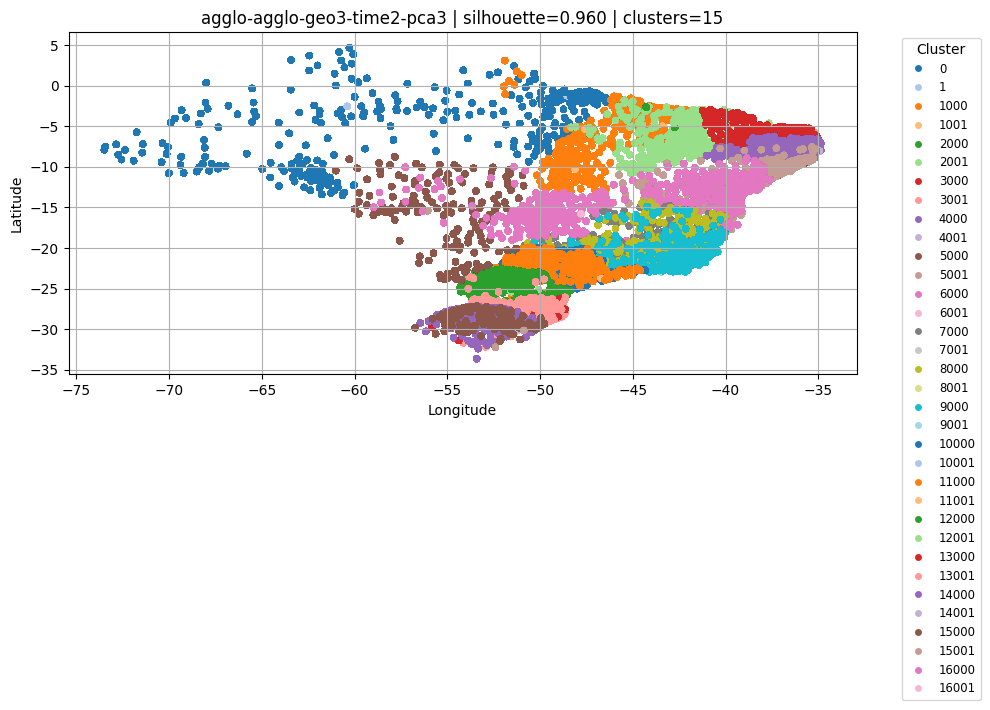

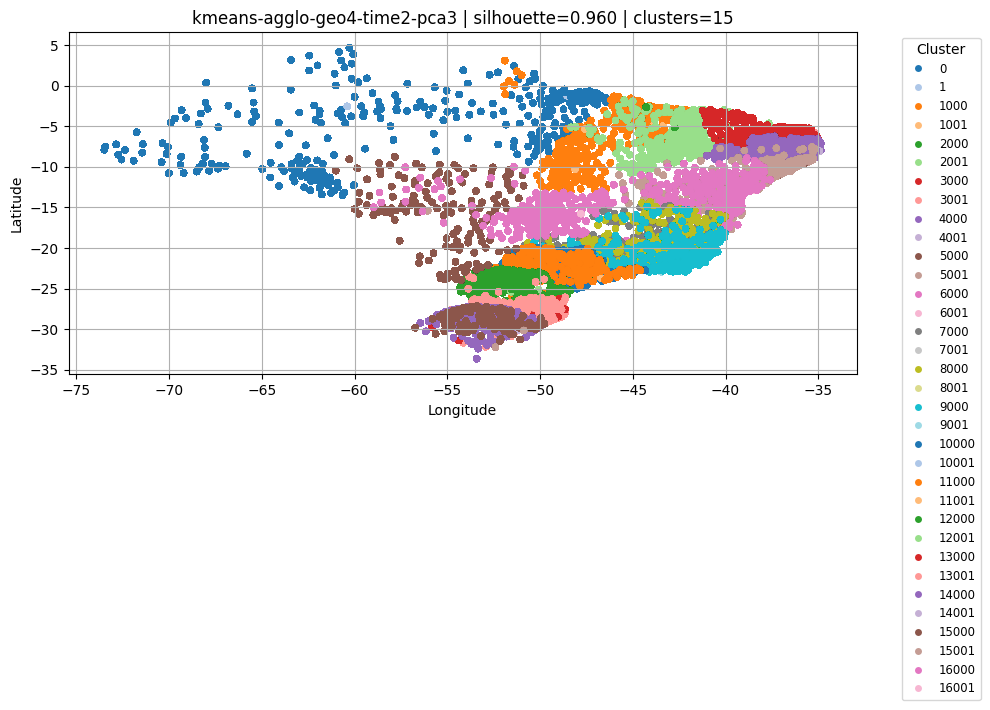

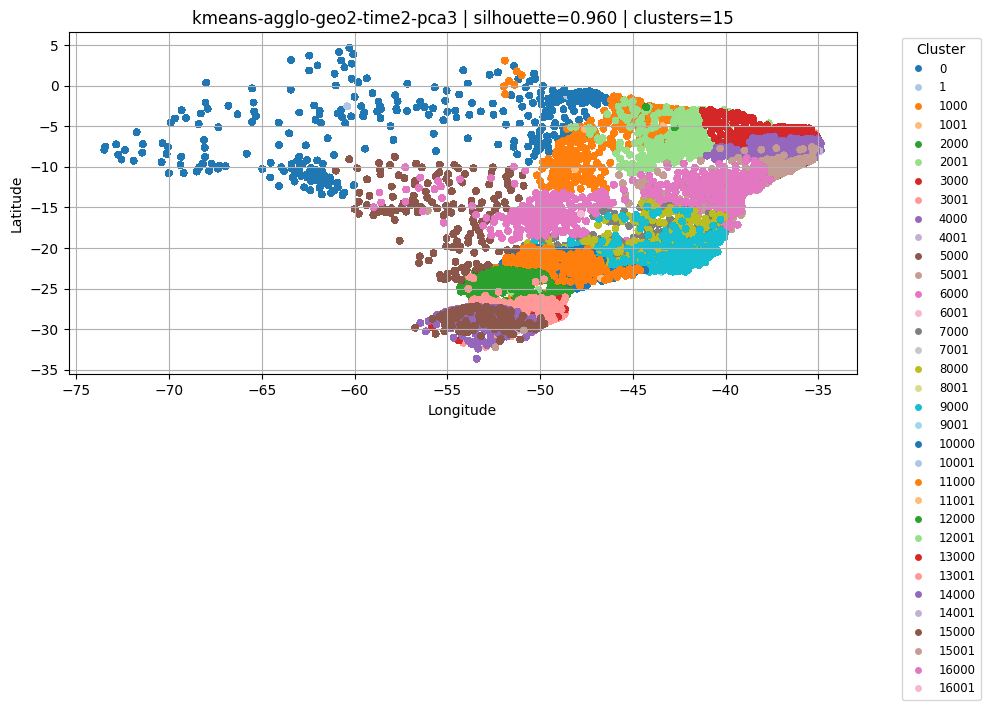

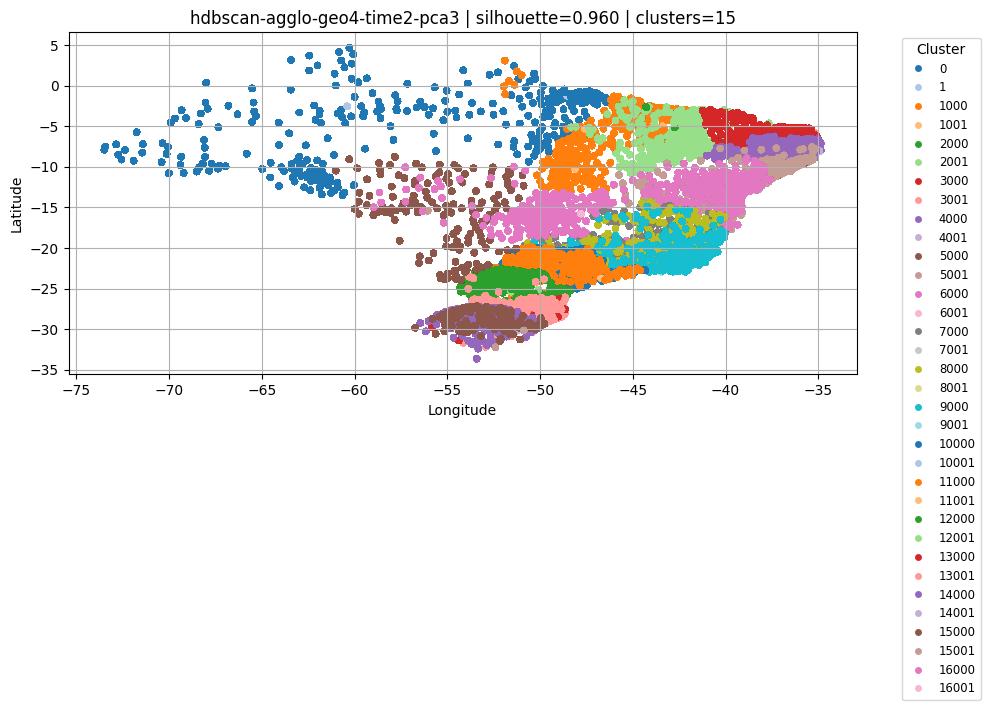

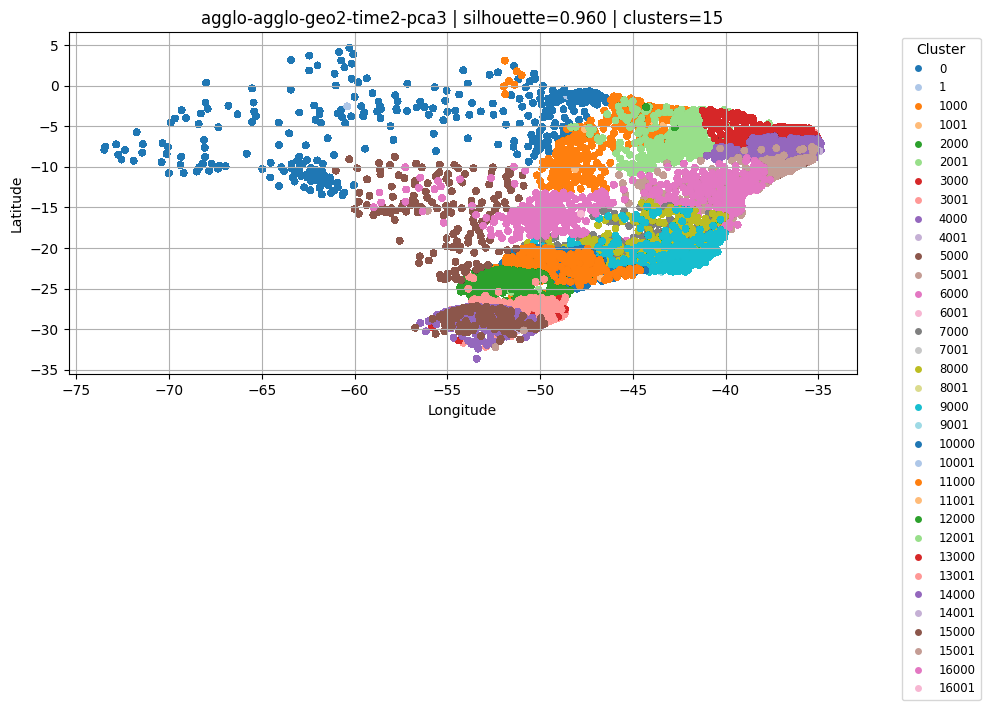

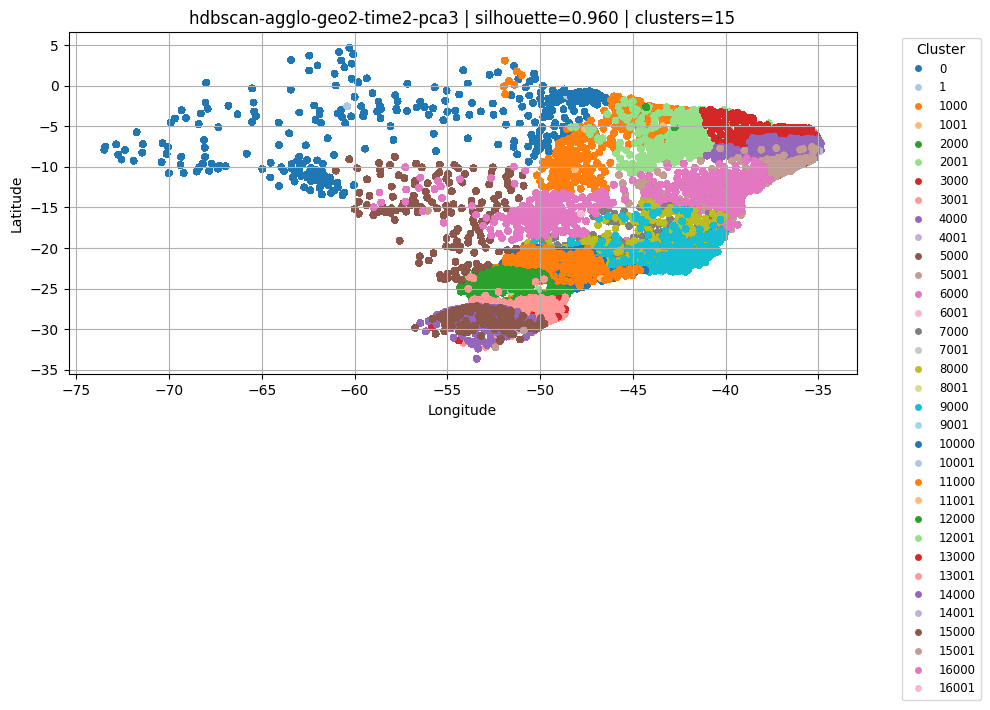

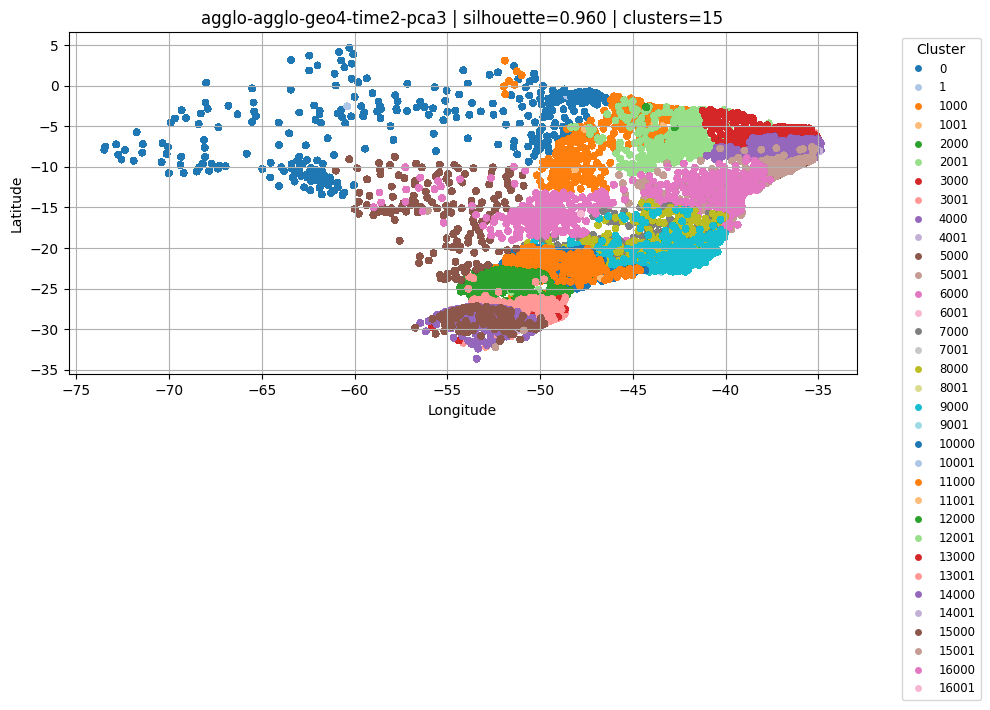

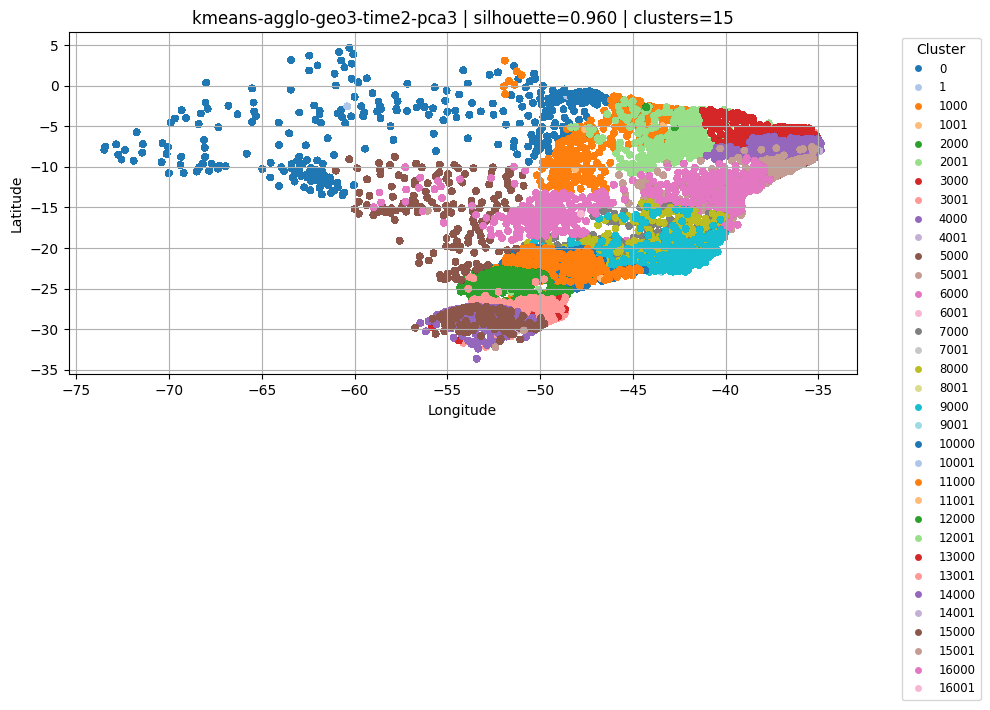

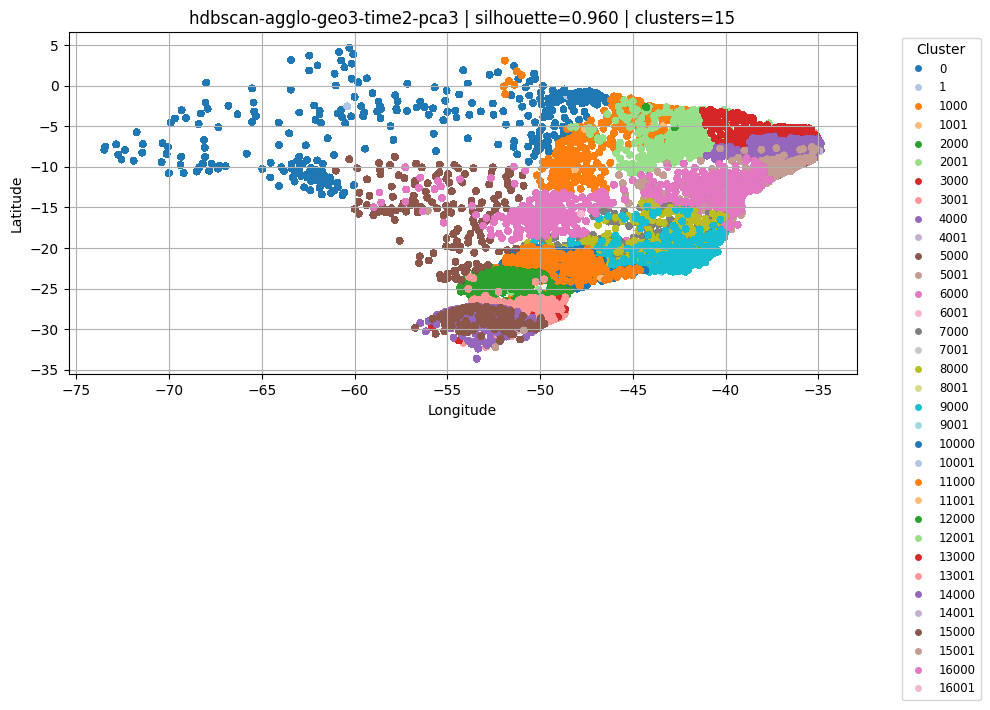

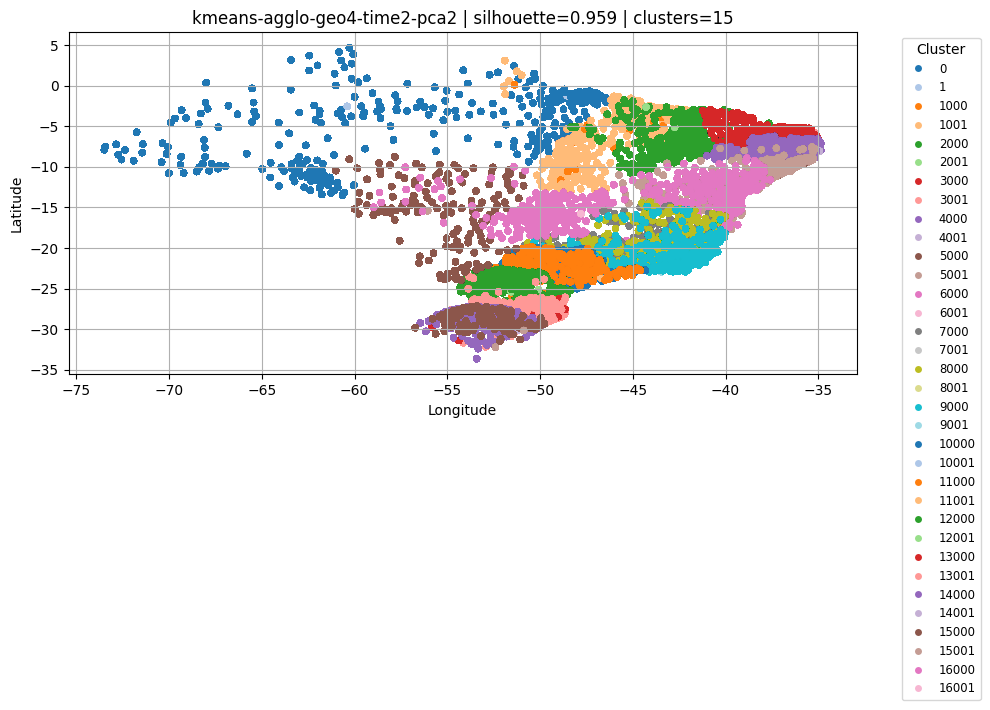

,N_municípios
cluster_final,
3000,358800
4000,358800
14000,358800
11000,358800
7000,358800
6000,358800
8000,358800
9000,358800
10000,358800


NameError: name 'exog_cols' is not defined

In [27]:
# Substitua se necessário pelos nomes corretos de variáveis do seu notebook
plot_top_10_clusters(results_df, best_clusters, n_top=10)

# Escolha uma das clusterizações para analisar detalhadamente:
melhor_key = results_df.iloc[0]
key_str = f"{melhor_key['geo_alg']}-{melhor_key['time_alg']}-geo{melhor_key['n_geo']}-time{melhor_key['n_time']}-pca{melhor_key['pca']}"
df_cluster_top = best_clusters[key_str]

# Ver distribuição de municípios por cluster
cluster_distribution(df_cluster_top)

# Resumo das variáveis exógenas por cluster
resumo_exogenas(df_cluster_top, exog_cols)

# Plot da série temporal média por cluster
plot_series_media_por_cluster(df_cluster_top, target_col="target")


In [29]:
import matplotlib.pyplot as plt
import seaborn as sns

# Função para visualização no mapa
def plot_top_10_clusters(results_df, best_clusters_dict, n_top=10):
    top_scenarios = results_df.head(n_top)

    for i, row in top_scenarios.iterrows():
        key = f"{row['geo_alg']}-{row['time_alg']}-geo{row['n_geo']}-time{row['n_time']}-pca{row['pca']}"
        df_clusters = best_clusters_dict.get(key)

        if df_clusters is None:
            print(f"⚠️ Cluster não encontrado para {key}")
            continue

        plt.figure(figsize=(10, 6))
        sns.scatterplot(
            data=df_clusters.dropna(subset=["cluster_final"]),
            x="LON", y="LAT", hue="cluster_final", palette="tab20", s=25, linewidth=0
        )
        plt.title(f"{key} | silhouette={row['silhouette']:.3f} | clusters={row['n_clusters']}")
        plt.xlabel("Longitude")
        plt.ylabel("Latitude")
        plt.grid(True)
        plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', title="Cluster", fontsize="small")
        plt.tight_layout()
        plt.show()

# Função corrigida: remove duplicatas para não contar várias semanas do mesmo município
def cluster_distribution(df_clusters):
    df_unique = df_clusters.drop_duplicates("CD_MUN")
    dist = df_unique["cluster_final"].value_counts().sort_values(ascending=False)
    display(dist.to_frame("N_municípios"))

# Resumo dos valores médios das variáveis exógenas por cluster
def resumo_exogenas(df_clusters, exog_cols):
    df_unique = df_clusters.drop_duplicates("CD_MUN")
    resumo = df_unique.groupby("cluster_final")[exog_cols].mean().round(2)
    display(resumo)

# Gráfico da série média por cluster
def plot_series_media_por_cluster(df_clusters, target_col="target"):
    series = df_clusters.pivot_table(
        index="week", columns="cluster_final", values=target_col, aggfunc="mean"
    )
    series.plot(figsize=(12, 5))
    plt.title("Série temporal média por cluster")
    plt.ylabel(target_col)
    plt.xlabel("Semana")
    plt.grid(True)
    plt.tight_layout()
    plt.show()


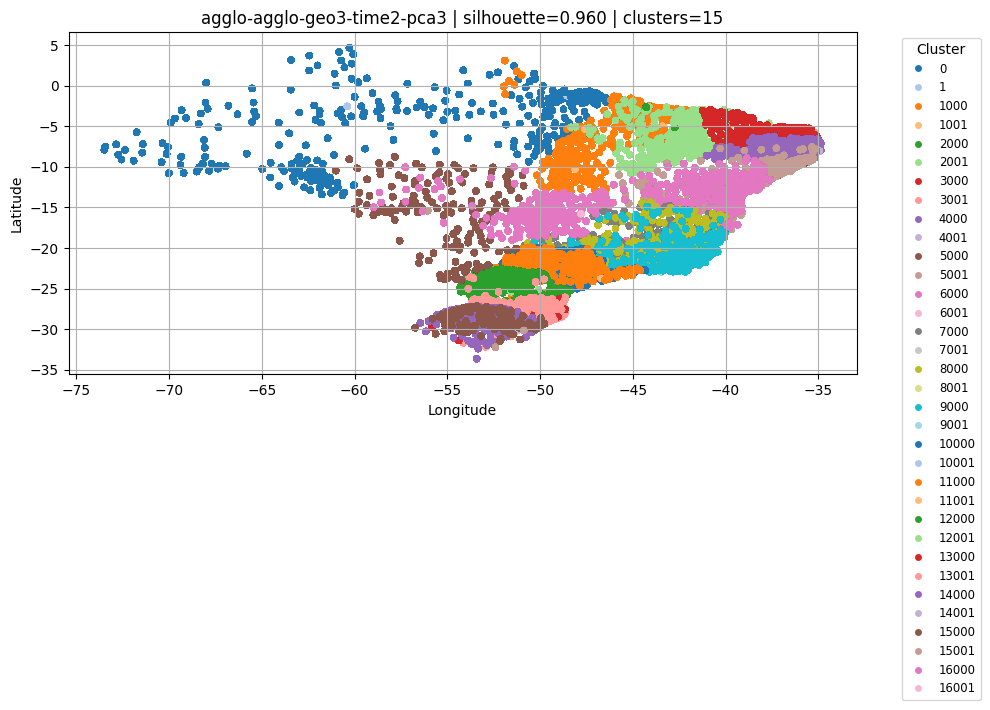

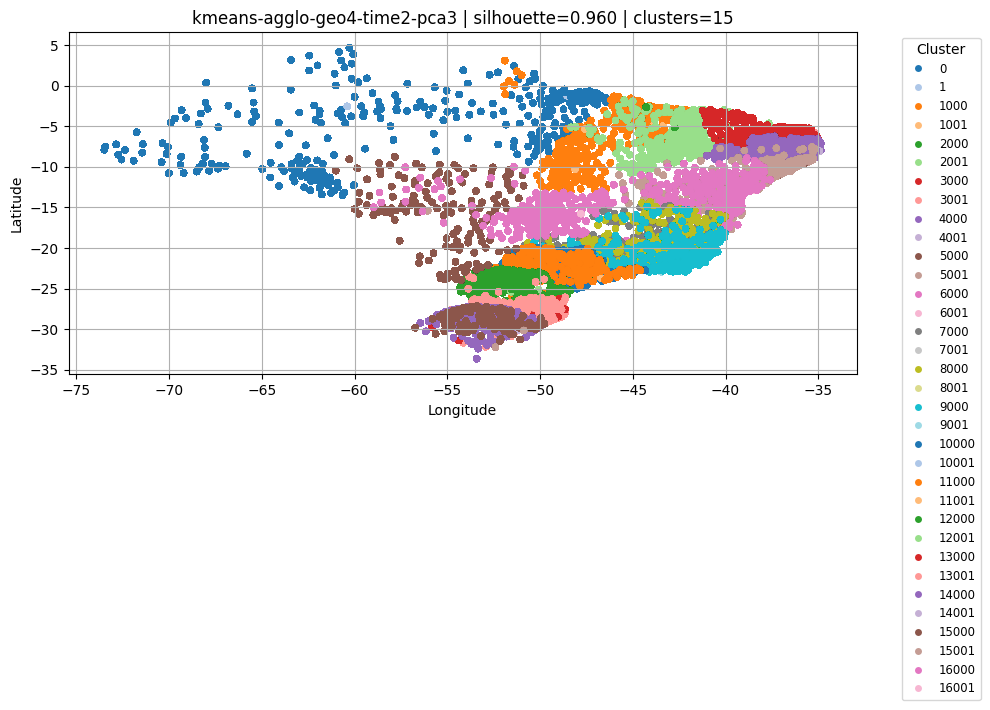

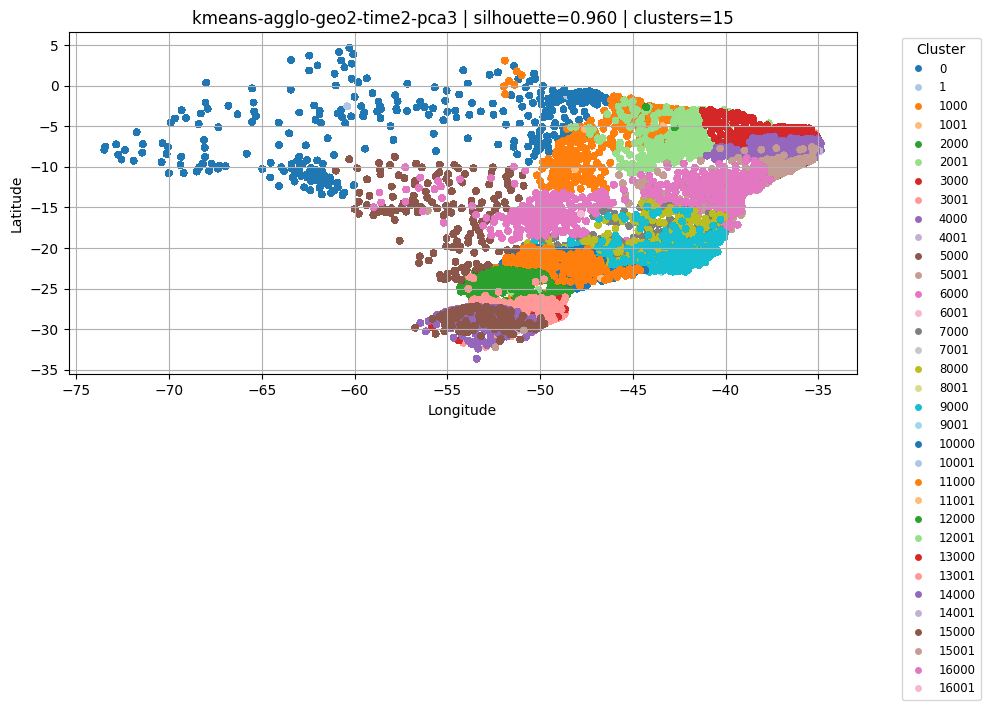

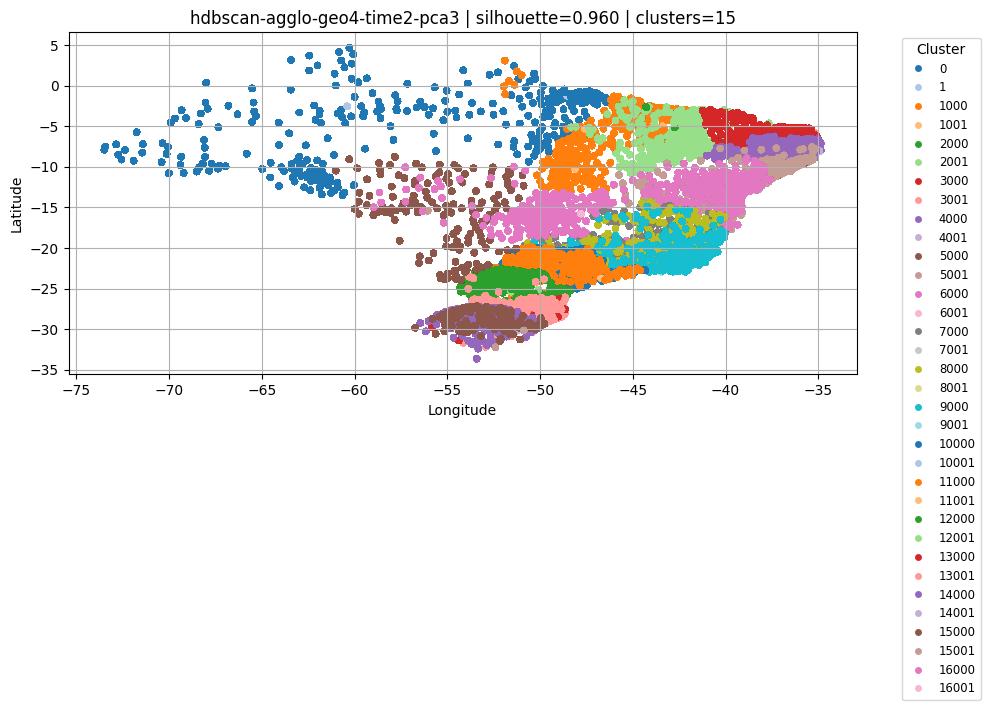

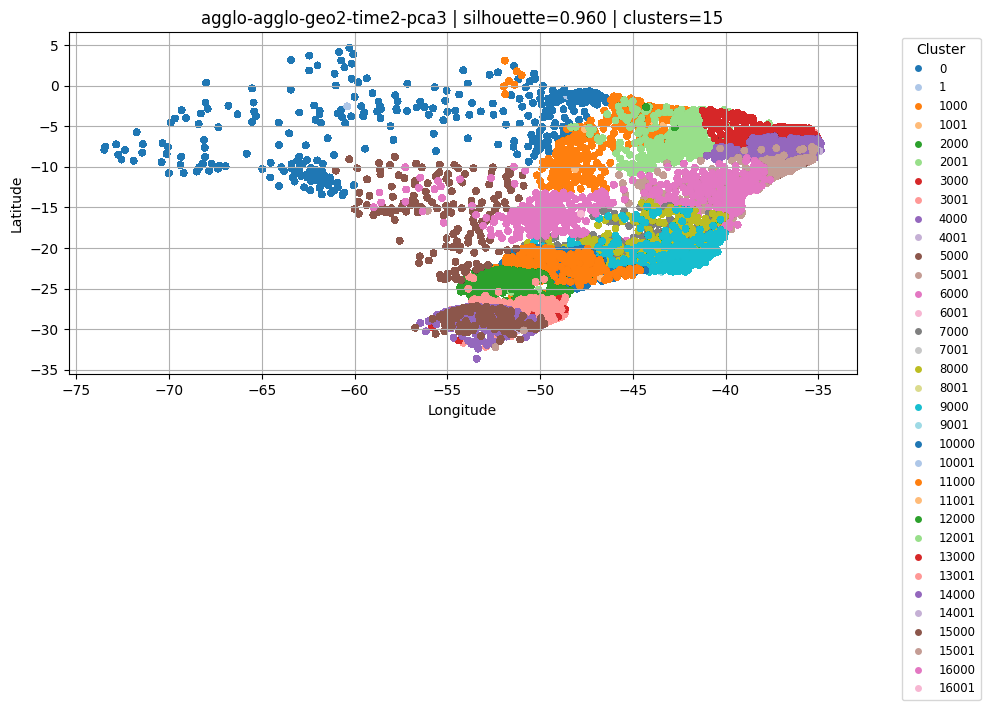

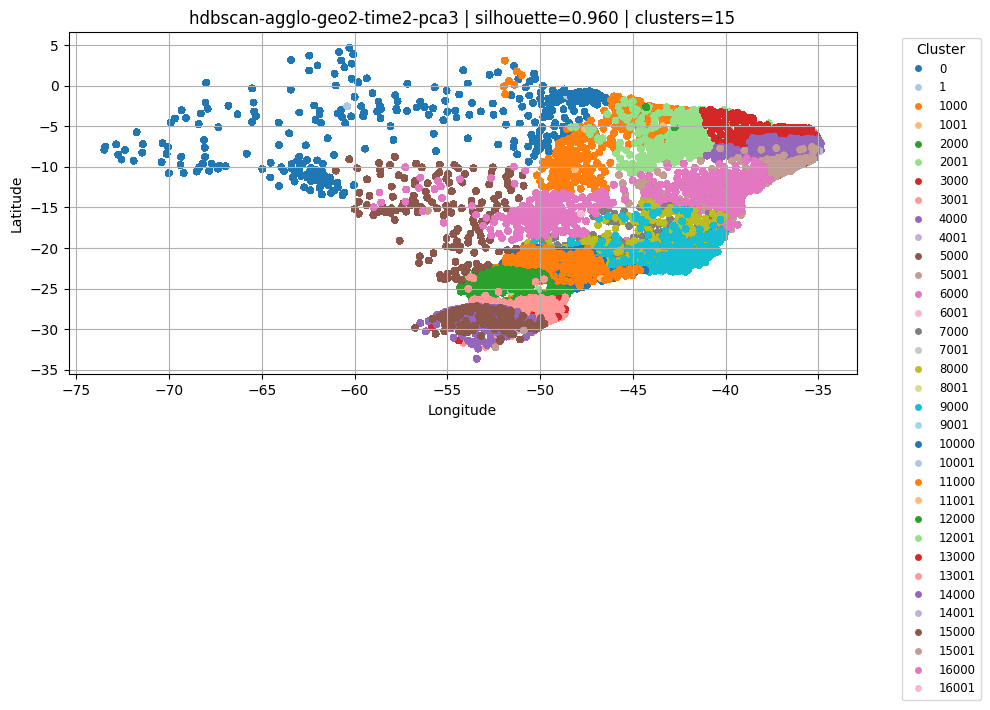

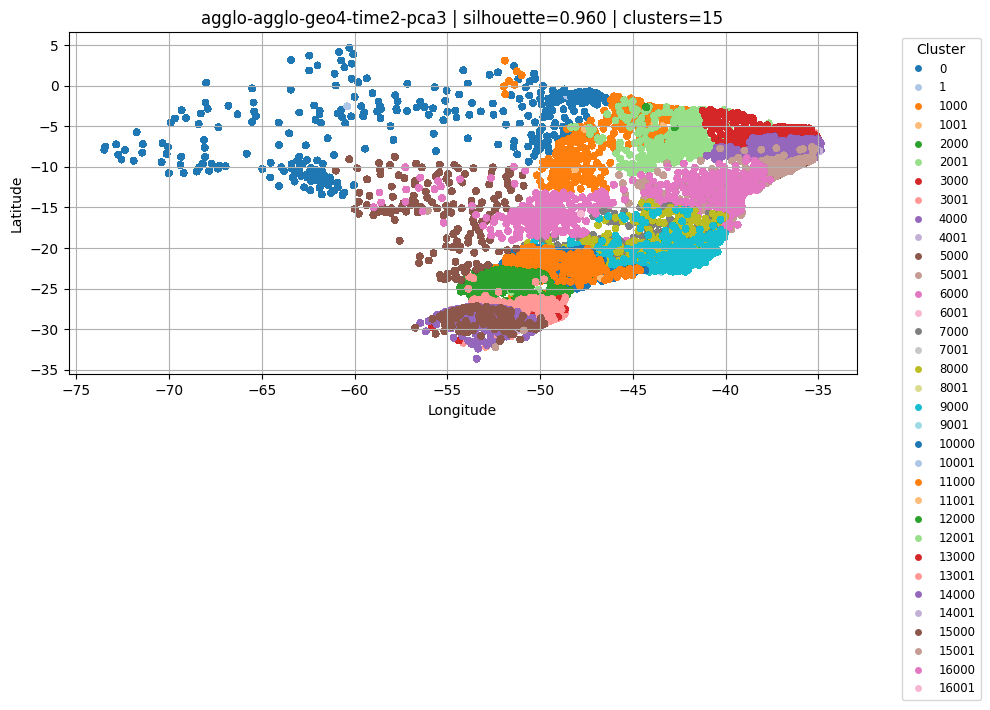

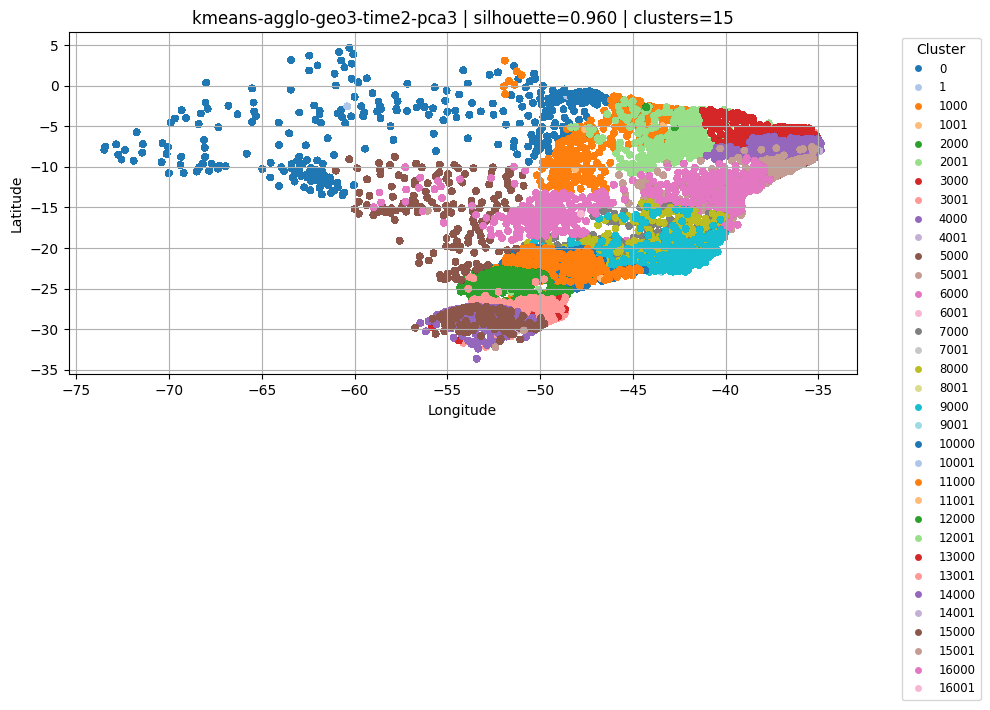

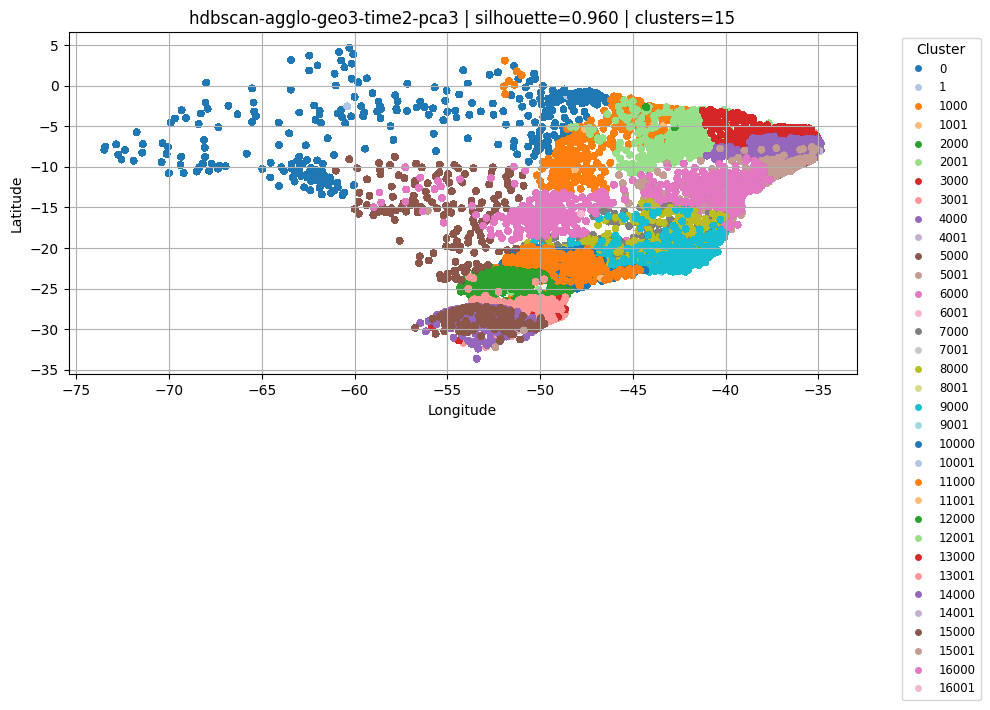

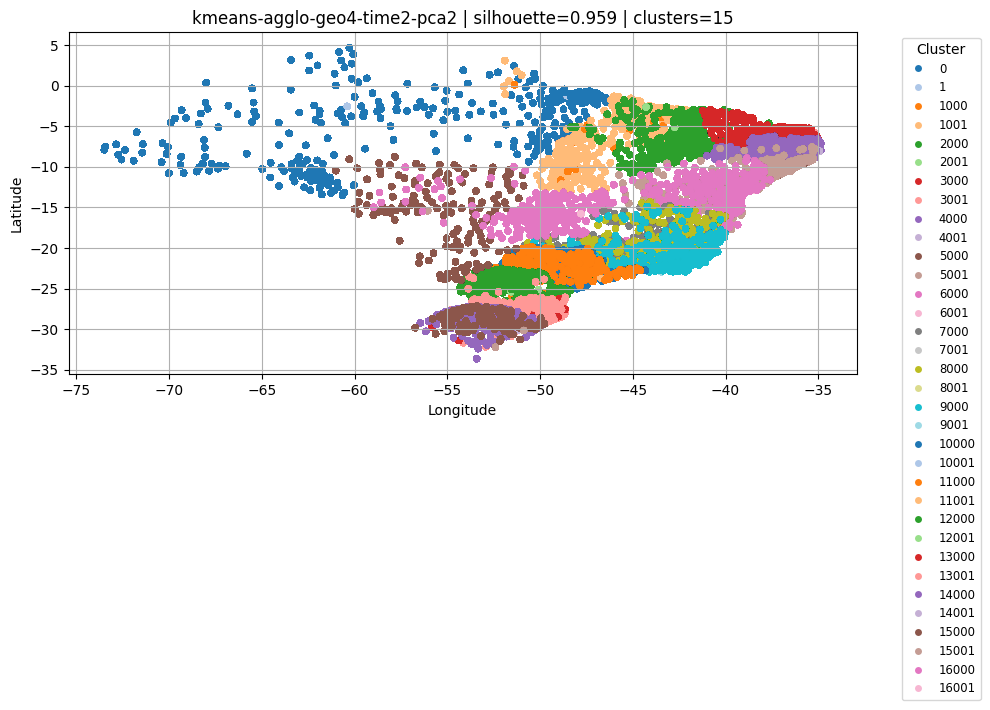

,N_municípios
cluster_final,
3000,299
4000,299
14000,299
11000,299
7000,299
6000,299
8000,299
9000,299
10000,299


,PIB,DENS,URB,CO2,CH4,N2O,LAT,LON
cluster_final,,,,,,,,
0,2481.48,19.03,0.00,7565.33,70.66,3.83,-4.71,-56.87
1,6398.20,615.19,0.06,76854.59,525.97,3.88,-1.88,-54.47
1000,1952.16,13.95,0.00,3643.88,68.00,4.11,-6.41,-46.61
1001,1958.82,118.97,0.03,11044.08,121.12,4.74,-5.59,-45.74
2000,4114.44,966.93,0.13,87850.63,6594.65,10.80,-3.87,-43.51
2001,1232.41,18.06,0.00,3269.33,45.41,2.79,-6.23,-42.72
3000,1681.38,47.22,0.00,12981.58,123.30,4.66,-5.74,-37.71
3001,4899.91,4115.59,0.46,193437.17,2094.69,11.49,-5.80,-35.22
4000,1575.15,84.04,0.01,18626.65,143.60,5.81,-7.57,-36.89


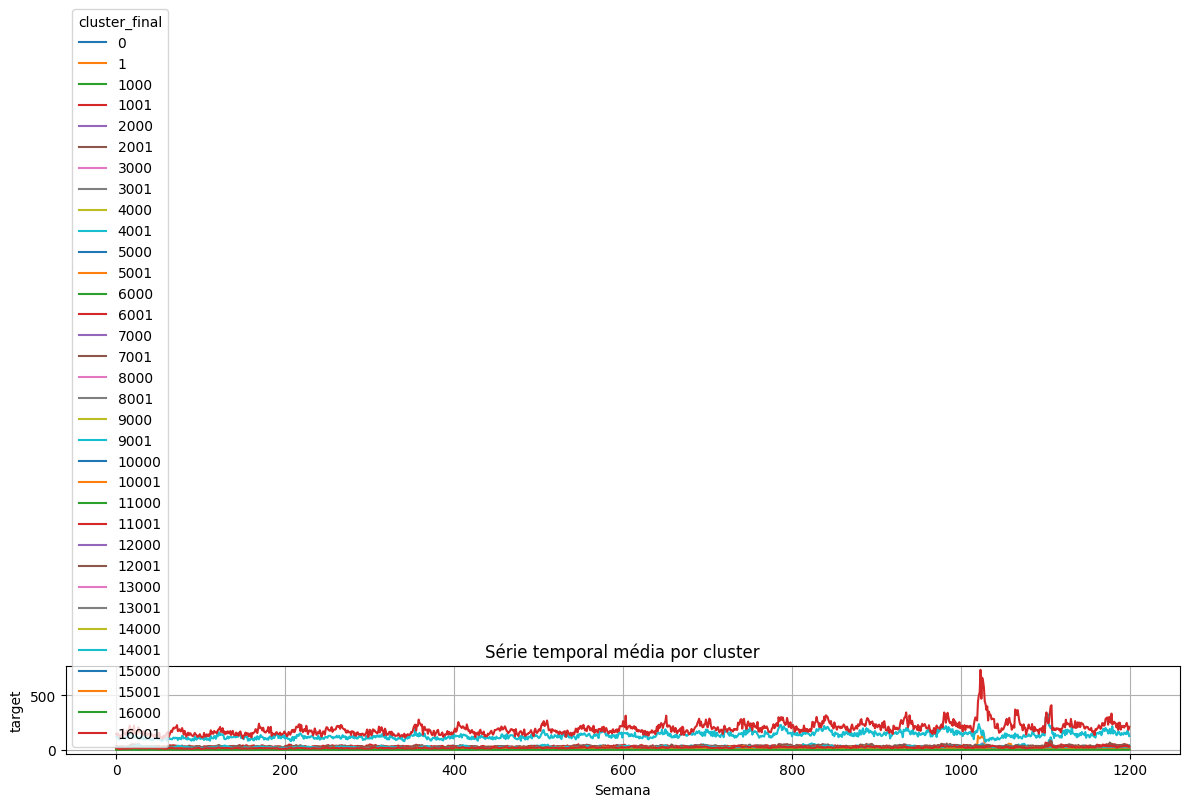

In [30]:
# Plot dos 10 melhores clusters no mapa
plot_top_10_clusters(results_df, best_clusters, n_top=10)

# Pega o melhor cluster para análise aprofundada
melhor_key = results_df.iloc[0]
key_str = f"{melhor_key['geo_alg']}-{melhor_key['time_alg']}-geo{melhor_key['n_geo']}-time{melhor_key['n_time']}-pca{melhor_key['pca']}"
df_cluster_top = best_clusters[key_str]

# Redefine exog_cols para não dar erro
exog_cols = ["PIB", "DENS", "URB", "CO2", "CH4", "N2O", "LAT", "LON"]

# Ver distribuição real de municípios por cluster
cluster_distribution(df_cluster_top)

# Ver médias das variáveis exógenas por cluster
resumo_exogenas(df_cluster_top, exog_cols)

# Ver a série temporal média por cluster
plot_series_media_por_cluster(df_cluster_top, target_col="target")


In [31]:
import os

def salvar_top_clusters(results_df, best_clusters_dict, pasta_saida="top_clusters_salvos", n_top=10):
    os.makedirs(pasta_saida, exist_ok=True)
    top_scenarios = results_df.head(n_top)

    for i, row in top_scenarios.iterrows():
        key = f"{row['geo_alg']}-{row['time_alg']}-geo{row['n_geo']}-time{row['n_time']}-pca{row['pca']}"
        df_clusters = best_clusters_dict.get(key)
        if df_clusters is None:
            continue

        df_out = df_clusters[["CD_MUN", "cluster_final"]].drop_duplicates()
        nome_arquivo = f"{key}_clusters.csv"
        df_out.to_csv(os.path.join(pasta_saida, nome_arquivo), index=False)

salvar_top_clusters(results_df, best_clusters, n_top=10)


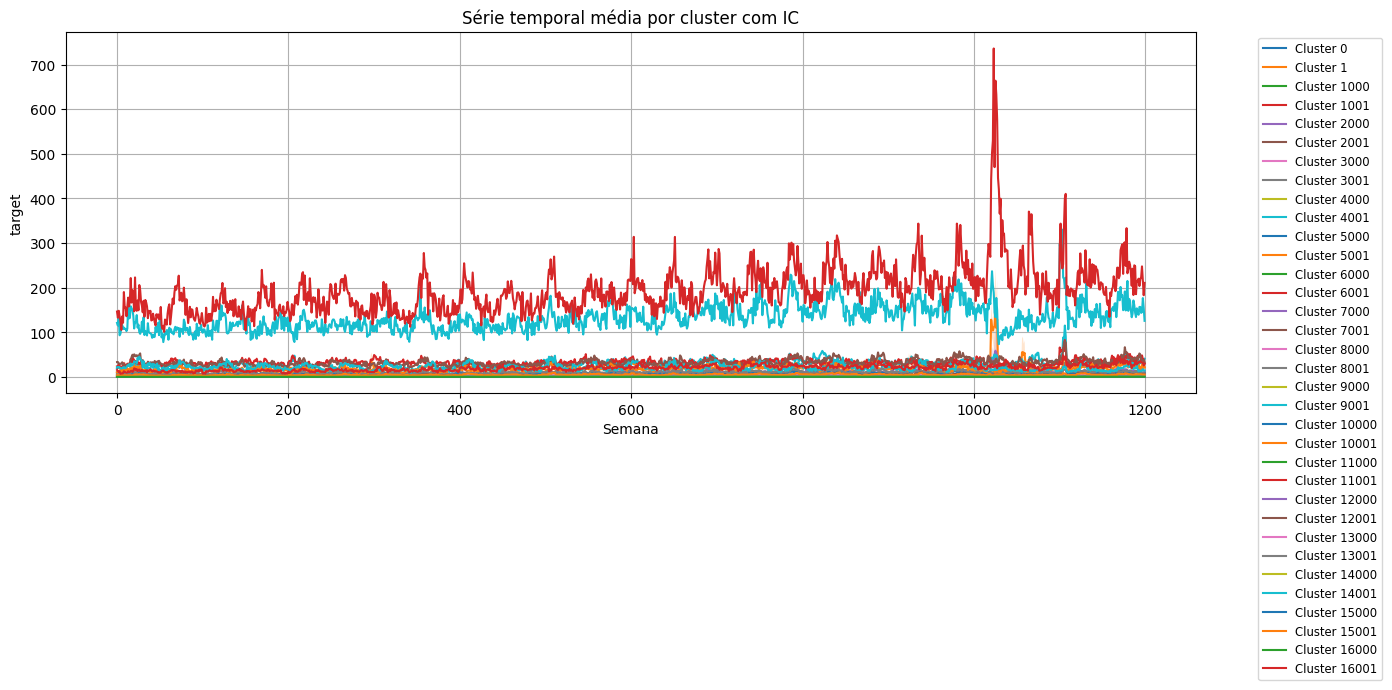

In [32]:
def plot_series_com_ic(df, target_col="target"):
    df["week"] = df["week"].astype(int)
    series_stats = df.groupby(["week", "cluster_final"])[target_col].agg(['mean', 'std', 'count']).reset_index()
    series_stats["sem"] = series_stats["std"] / np.sqrt(series_stats["count"])
    
    plt.figure(figsize=(14, 6))
    for cluster in series_stats["cluster_final"].unique():
        dados = series_stats[series_stats["cluster_final"] == cluster]
        plt.plot(dados["week"], dados["mean"], label=f"Cluster {cluster}")
        plt.fill_between(dados["week"], dados["mean"] - dados["sem"], dados["mean"] + dados["sem"], alpha=0.2)

    plt.title("Série temporal média por cluster com IC")
    plt.xlabel("Semana")
    plt.ylabel(target_col)
    plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left", fontsize="small")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Usando o melhor cluster
plot_series_com_ic(df_cluster_top, target_col="target")


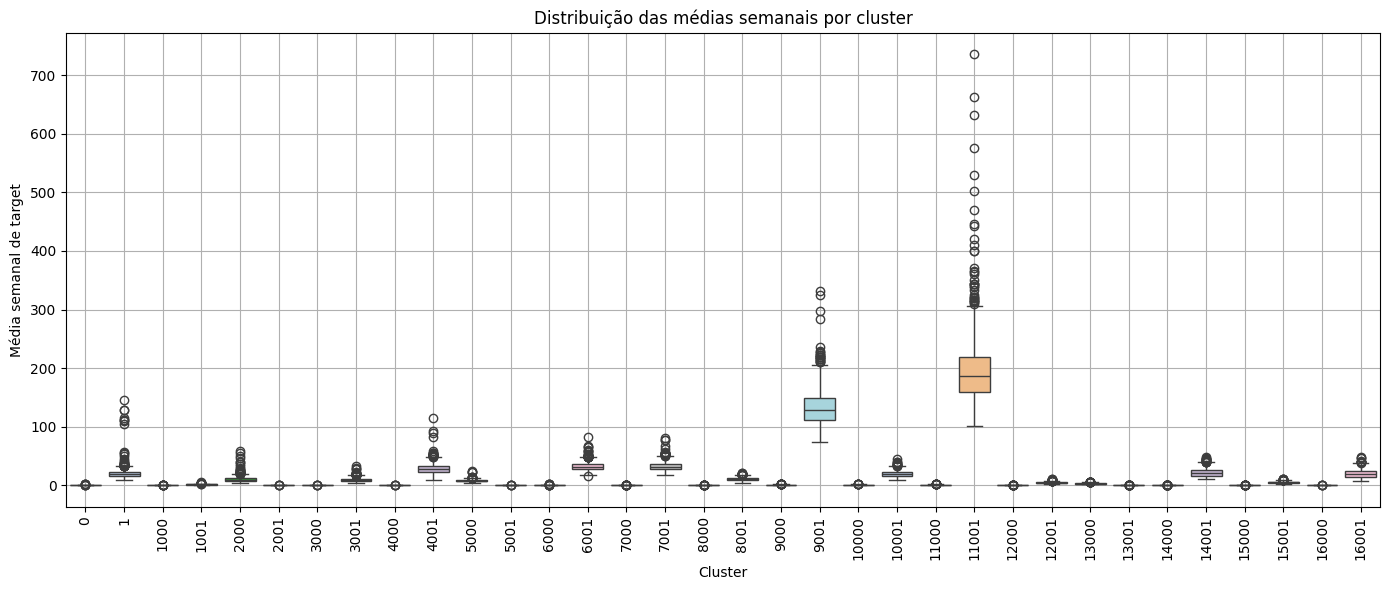

In [33]:
def boxplot_series_por_cluster(df, target_col="target"):
    agg = df.groupby(["cluster_final", "week"])[target_col].mean().reset_index()
    plt.figure(figsize=(14, 6))
    sns.boxplot(data=agg, x="cluster_final", y=target_col, palette="tab20")
    plt.title("Distribuição das médias semanais por cluster")
    plt.xlabel("Cluster")
    plt.ylabel(f"Média semanal de {target_col}")
    plt.xticks(rotation=90)
    plt.grid(True)
    plt.tight_layout()
    plt.show()

boxplot_series_por_cluster(df_cluster_top, target_col="target")
